In [1]:
%cd ..

/home/alberto/PycharmProjects/incomplete_multiview_clustering


In [2]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from imvc.datasets import LoadDataset
from imvc.decomposition import jNMF
from imvc.preprocessing import MultiViewTransformer, ConcatenateViews, DropView
from imvc.ampute import Amputer
import matplotlib
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from functools import reduce
from sklearn.preprocessing import FunctionTransformer
from imvc.feature_selection import jNMFFeatureSelector
from sklearn.metrics import accuracy_score

Maximum number of clients reachedMaximum number of clients reached

In [3]:
from tueplots import axes, bundles
plt.rcParams.update({**bundles.icml2022(), **axes.lines()})

In [4]:
Xs, y = LoadDataset.load_dataset(dataset_name="nutrimouse", return_y=True)

In [5]:
ps = np.arange(0.1, 0.9, 0.2)
n_components_list = [1, 2, 4, 8, 16, 32]
n_times = 50
mechanism = "pm"
all_metrics = {}

In [6]:
key = "jNMF"
all_metrics[key] = {}
for p in tqdm(ps):
    missing_percentage = int(p*100)
    all_metrics[key][missing_percentage] = {}
    for n_components in n_components_list:
        all_metrics[key][missing_percentage][n_components] = {}
        for i in range(n_times):
            amputed_Xs = Amputer(p= p, mechanism=mechanism, random_state=i).fit_transform(Xs)
            for X in amputed_Xs:
                X.iloc[np.random.default_rng(i).choice([True, False], p= [p,1-p], size = X.shape)] = np.nan
            masks = [np.isnan(amputed_X) for amputed_X in amputed_Xs]
            pipeline = make_pipeline(MultiViewTransformer(MinMaxScaler().set_output(transform="pandas")),
                                     jNMF(n_components = n_components, random_state=i))
            try:
                transformed_X = pipeline.fit_transform(amputed_Xs)
                metric = np.mean([mean_squared_error(X.values[mask], np.dot(transformed_X + V, H.T)[mask]) 
                                  for X,V,H,mask in zip(pipeline[0].transform(Xs), pipeline[-1].V_, pipeline[-1].H_, masks)])
                all_metrics[key][missing_percentage][n_components][i] = metric
            except:
                pass

  0%|          | 0/4 [00:00<?, ?it/s]

In [7]:
key = "Baseline"
all_metrics[key] = {}
for p in tqdm(ps):
    missing_percentage = int(p*100)
    all_metrics[key][missing_percentage] = {}
    for n_components in n_components_list:
        all_metrics[key][missing_percentage][n_components] = {}
        for i in range(n_times):
            amputed_Xs = Amputer(p= p, mechanism=mechanism, random_state=i).fit_transform(Xs)
            for X in amputed_Xs:
                X.iloc[np.random.default_rng(i).choice([True, False], p= [p,1-p], size = X.shape)] = np.nan
            masks = [np.isnan(amputed_X) for amputed_X in amputed_Xs]
            pipeline = make_pipeline(MultiViewTransformer(MinMaxScaler().set_output(transform="pandas")),
                                     MultiViewTransformer(SimpleImputer().set_output(transform="pandas")))
            try:
                transformed_Xs = pipeline.fit_transform(amputed_Xs)
                metric = np.mean([mean_squared_error(X.values[mask], transformed_X.values[mask]) 
                                  for X,transformed_X,mask in zip(pipeline[0].transform(Xs), transformed_Xs, masks)])
                all_metrics[key][missing_percentage][n_components][i] = metric
            except:
                pass

  0%|          | 0/4 [00:00<?, ?it/s]

In [8]:
flattened_data = [
    {
        'Method': method,
        'Missing rate (\%)': p,
        'Components': n_comp,
        **n_dict
    }
    for method, method_dict in all_metrics.items()
    for p, p_dict in method_dict.items()
    for n_comp, n_dict in p_dict.items()
]
df = pd.DataFrame(flattened_data)
df = df.melt(id_vars=['Method', 'Missing rate (\%)', "Components"], var_name='Iteration', value_name='Reconstruction error (MSE)')
df = df.sort_values(["Missing rate (\%)", "Method", "Components", "Iteration"], ascending=[True, False, True, True])
df.to_csv("tutorials/reduction_results.csv", index= None)
df

,Method,Missing rate (\%),Components,Iteration,Reconstruction error (MSE)
0,jNMF,10,1,0,0.076149
48,jNMF,10,1,1,0.061625
96,jNMF,10,1,2,0.057852
144,jNMF,10,1,3,0.064574
192,jNMF,10,1,4,0.067845
...,...,...,...,...,...
2207,Baseline,70,32,45,2.543549
2255,Baseline,70,32,46,NaN
2303,Baseline,70,32,47,NaN
2351,Baseline,70,32,48,NaN


In [9]:
df = pd.read_csv("tutorials/reduction_results.csv")
df

,Method,Missing rate (\%),Components,Iteration,Reconstruction error (MSE)
0,jNMF,10,1,0,0.076149
1,jNMF,10,1,1,0.061625
2,jNMF,10,1,2,0.057852
3,jNMF,10,1,3,0.064574
4,jNMF,10,1,4,0.067845
...,...,...,...,...,...
2395,Baseline,70,32,45,2.543549
2396,Baseline,70,32,46,NaN
2397,Baseline,70,32,47,NaN
2398,Baseline,70,32,48,NaN


In [10]:
diff_df = df.groupby(["Method", "Missing rate (\%)", "Components"]).mean()
diff_df = diff_df.groupby(["Method", "Missing rate (\%)"]).min() \
    .sort_values(["Method"], ascending=[False]) \
    .groupby(["Missing rate (\%)"]).agg({'Reconstruction error (MSE)': lambda L: reduce(np.divide, L)}) \
    .reset_index() \
    .merge(
        diff_df.loc[diff_df.groupby(["Method", "Missing rate (\%)"])["Reconstruction error (MSE)"].idxmin()] \
            .filter(like= "jNMF", axis= 0).reset_index()[["Missing rate (\%)"]])
diff_df["Reconstruction error (MSE) difference"] = 1 - diff_df["Reconstruction error (MSE)"]
diff_df = diff_df.drop(columns= "Reconstruction error (MSE)").round(3)
diff_df

,Missing rate (\%),Reconstruction error (MSE) difference
0,10,0.082
1,30,0.044
2,50,0.013
3,70,0.006


In [11]:
print(diff_df.to_latex())

\begin{tabular}{lrr}
\toprule
 & Missing rate (\%) & Reconstruction error (MSE) difference \\
\midrule
0 & 10 & 0.082000 \\
1 & 30 & 0.044000 \\
2 & 50 & 0.013000 \\
3 & 70 & 0.006000 \\
\bottomrule
\end{tabular}



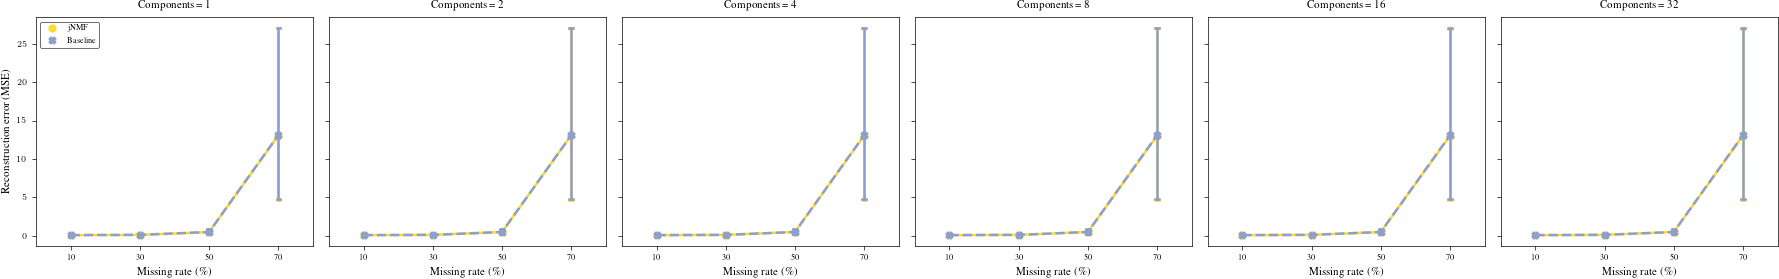

In [12]:
g = sns.FacetGrid(data=df, col="Components", despine=False).map_dataframe(sns.pointplot, x="Missing rate (\%)", y="Reconstruction error (MSE)",
                                                                          hue="Method", markers=["o", "X"], linestyles=["-", "--"], capsize= 0.05,
                                                                          seed= 42, palette= "Set2_r")
g.axes[0][0].legend(loc='upper left')
plt.savefig("paper_figures/reduction_a.pdf")
plt.savefig("paper_figures/reduction_a.svg")

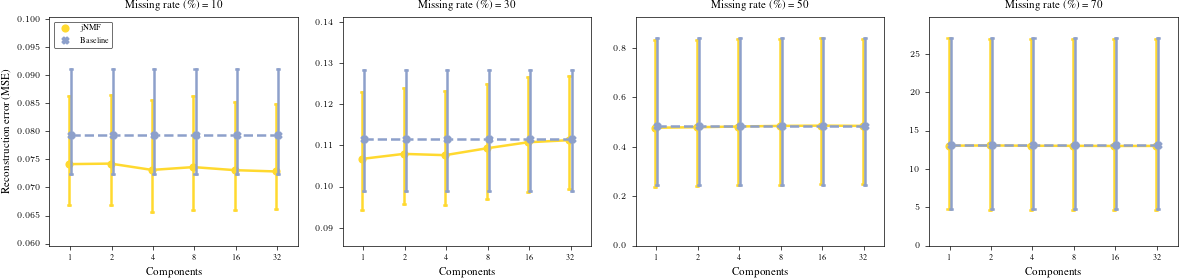

In [13]:
g = sns.FacetGrid(data=df, col="Missing rate (\%)", despine=False, sharey=False).map_dataframe(sns.pointplot, x="Components",
                                                                                               y="Reconstruction error (MSE)", hue="Method",
                                                                                               markers=["o", "X"], linestyles=["-", "--"],
                                                                                               capsize= 0.05, seed= 42, palette= "Set2_r", dodge=True)
g.axes[0][0].legend(loc='upper left')
for ax in g.axes[0]:
    values = [j for i in ax.lines for j in i.get_ydata()]
    if any(np.array(values)> 0.5):
        min_y = 0
        max_y = max(values) * 1.1
    else:
        min_y = min(values) / 1.1
        max_y = max(values) * 1.1
    ax.set_ylim((min_y, max_y))
plt.savefig("paper_figures/reduction_b.pdf")
plt.savefig("paper_figures/reduction_b.svg")

In [14]:
y = y.iloc[:,0]
y.value_counts()

genotype
1    20
0    20
Name: count, dtype: int64

In [15]:
ps = np.arange(0, 0.9, 0.2)
n_components_list = [1, 2, 4, 8, 16, 32]
n_times = 50
all_metrics = {}

In [16]:
key = "jNMF"
all_metrics[key] = {}
for p in tqdm(ps):
    missing_percentage = int(p*100)
    all_metrics[key][missing_percentage] = {}
    for n_components in n_components_list:
        all_metrics[key][missing_percentage][n_components] = {}
        for i in range(n_times):
            Xs_train = Amputer(p= p, mechanism=mechanism, random_state=i).fit_transform(Xs)
            for X in Xs_train:
                X.iloc[np.random.default_rng(i).choice([True, False], p= [p,1-p], size = X.shape)] = np.nan
            pipeline = make_pipeline(MultiViewTransformer(MinMaxScaler().set_output(transform="pandas")),
                                     jNMF(n_components = n_components, random_state=i),
                                     )
            transformed_X = pipeline.fit_transform(Xs_train)
            preds = SVC(random_state=i).fit(transformed_X, y).predict(transformed_X)
            try:
                metric = accuracy_score(y_pred=preds, y_true=y)
                all_metrics[key][missing_percentage][n_components][i] = metric
            except:
                pass

  0%|          | 0/5 [00:00<?, ?it/s]

In [17]:
key = "jNMFFS"
all_metrics[key] = {}
for p in tqdm(ps):
    missing_percentage = int(p*100)
    all_metrics[key][missing_percentage] = {}
    for n_components in n_components_list:
        all_metrics[key][missing_percentage][n_components] = {}
        for i in range(n_times):
            Xs_train = Amputer(p= p, mechanism=mechanism, random_state=i).fit_transform(Xs)
            for X in Xs_train:
                X.iloc[np.random.default_rng(i).choice([True, False], p= [p,1-p], size = X.shape)] = np.nan
            pipeline = make_pipeline(MultiViewTransformer(MinMaxScaler().set_output(transform="pandas")),
                                     jNMFFeatureSelector(n_components = n_components, random_state=i),
                                     FunctionTransformer(lambda x: np.concatenate(x, axis=1)),
                                     SimpleImputer(),
                                     )
            transformed_X = pipeline.fit_transform(Xs_train)
            preds = SVC(random_state=i).fit(transformed_X, y).predict(transformed_X)
            try:
                metric = accuracy_score(y_pred=preds, y_true=y)
                all_metrics[key][missing_percentage][n_components][i] = metric
            except:
                pass

  0%|          | 0/5 [00:00<?, ?it/s]

In [18]:
key = "Baseline"
all_metrics[key] = {}
for p in tqdm(ps):
    missing_percentage = int(p*100)
    all_metrics[key][missing_percentage] = {}
    for n_components in n_components_list:
        all_metrics[key][missing_percentage][n_components] = {}
        for i in range(n_times):
            Xs_train = Amputer(p= p, mechanism=mechanism, random_state=i).fit_transform(Xs)
            for X in Xs_train:
                X.iloc[np.random.default_rng(i).choice([True, False], p= [p,1-p], size = X.shape)] = np.nan
            pipeline = make_pipeline(MultiViewTransformer(MinMaxScaler().set_output(transform="pandas")),
                                     ConcatenateViews(),
                                     FunctionTransformer(lambda x: x.iloc[:,np.random.default_rng(i).integers(0, 141, size= n_components)]),
                                     SimpleImputer())
            try:
                transformed_X = pipeline.fit_transform(Xs_train)
                preds = SVC(random_state=i).fit(transformed_X, y).predict(transformed_X)
                metric = accuracy_score(y_pred=preds, y_true=y)
                all_metrics[key][missing_percentage][n_components][i] = metric
            except:
                pass

  0%|          | 0/5 [00:00<?, ?it/s]

In [19]:
flattened_data = [
    {
        'Method': method,
        'Missing rate (\%)': p,
        'Components': n_comp,
        **n_dict
    }
    for method, method_dict in all_metrics.items()
    for p, p_dict in method_dict.items()
    for n_comp, n_dict in p_dict.items()
]
df = pd.DataFrame(flattened_data)
df = df.melt(id_vars=['Method', 'Missing rate (\%)', "Components"], var_name='Iteration',
             value_name='Accuracy')
df = df.sort_values(["Missing rate (\%)", "Method", "Components", "Iteration"], ascending=[True, False, True, True])
df.to_csv("tutorials/selection_results.csv", index= None)
df

,Method,Missing rate (\%),Components,Iteration,Accuracy
30,jNMFFS,0,1,0,0.800
120,jNMFFS,0,1,1,0.800
210,jNMFFS,0,1,2,0.800
300,jNMFFS,0,1,3,0.800
390,jNMFFS,0,1,4,0.800
...,...,...,...,...,...
4139,Baseline,80,32,45,0.975
4229,Baseline,80,32,46,0.900
4319,Baseline,80,32,47,0.675
4409,Baseline,80,32,48,0.700


In [20]:
df = pd.read_csv("tutorials/selection_results.csv")

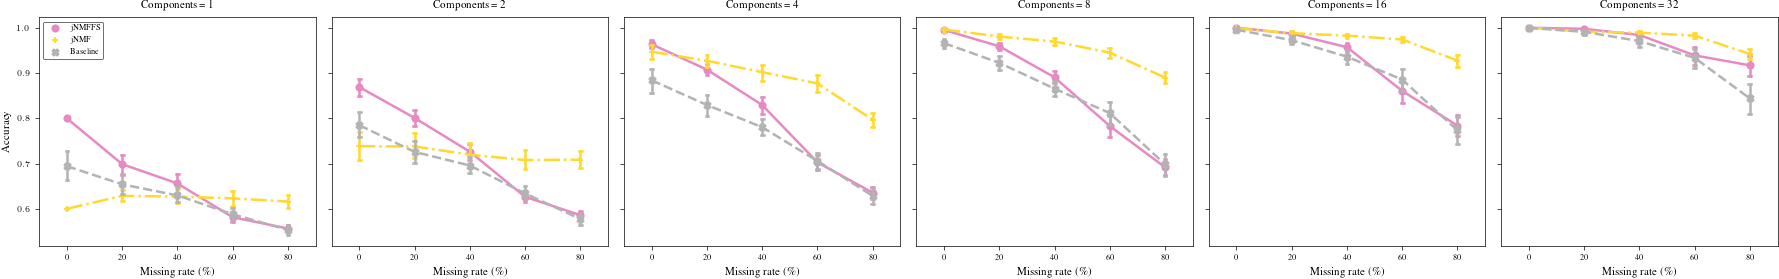

In [21]:
palette = [matplotlib.cm.get_cmap('Set2_r')(i) for i in range(df["Method"].nunique())]
palette[2] = matplotlib.cm.get_cmap('Set2_r')(4)
palette[1] = matplotlib.cm.get_cmap('Set2_r')(2)
palette.reverse()
g = sns.FacetGrid(data=df, col="Components", despine=False).map_dataframe(sns.pointplot, x="Missing rate (\%)", y="Accuracy", hue="Method",
                                                                          markers=["o", "+", "X"], linestyles=["-", "-.", "--"], capsize= 0.05, 
                                                                          seed= 42, palette=palette)
g.axes[0][0].legend(loc='upper left')
plt.savefig("paper_figures/selection_a.pdf")
plt.savefig("paper_figures/selection_a.svg")

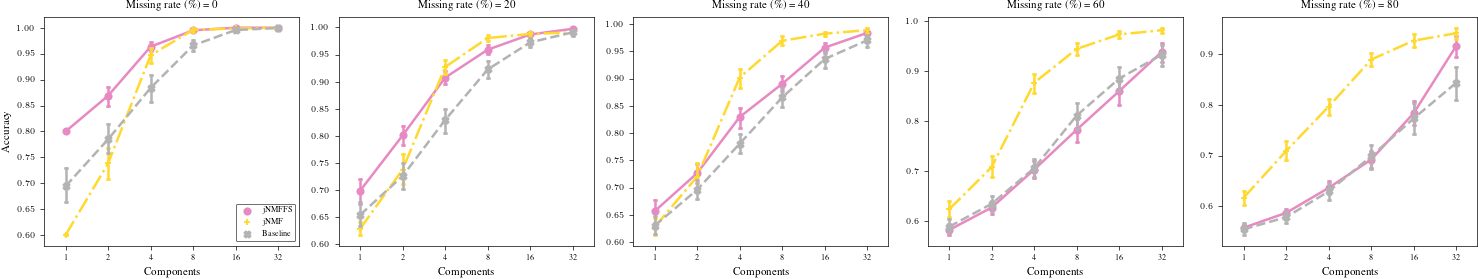

In [22]:
g = sns.FacetGrid(data=df, col="Missing rate (\%)", despine=False, sharey=False).map_dataframe(sns.pointplot, x="Components", y="Accuracy", hue="Method",
                                                                                               markers=["o", "+", "X"], linestyles=["-", "-.", "--"],
                                                                                               capsize= 0.05, seed= 42, palette=palette)
g.axes[0][0].legend(loc='lower right')
plt.savefig("paper_figures/selection_b.pdf")
plt.savefig("paper_figures/selection_b.svg")

In [23]:
p = 0.3
amputed_Xs = Amputer(p= p, mechanism=mechanism, random_state=42).fit_transform(Xs)
for X in amputed_Xs:
    X.iloc[np.random.default_rng(42).choice([True, False], p= [p,1-p], size = X.shape)] = np.nan
pipeline = make_pipeline(MultiViewTransformer(MinMaxScaler().set_output(transform="pandas")),
                         jNMFFeatureSelector(n_components = 8, random_state=42))
transformed_Xs = pipeline.fit(amputed_Xs)
selected_features = {"Feature": pipeline[-1].selected_features_, "Feature Importance": pipeline[-1].weights_}
selected_features = pd.DataFrame(selected_features).sort_values(by="Feature Importance", ascending= False)
selected_features = selected_features.reset_index(names="Component")
selected_features["Modality"] = selected_features["Feature"].apply(lambda x: "Genes" if ((x in Xs[0].columns) and (x not in Xs[1].columns)) \
    else ("Fatty Acids" if ((x in Xs[1].columns) and (x not in Xs[0].columns)) else "Not found"))
selected_features

,Component,Feature,Feature Importance,Modality
0,7,i.NOS,3.309179,Genes
1,0,TRa,3.153348,Genes
2,2,C20.3n.6,3.055109,Fatty Acids
3,6,SIAT4c,2.983462,Genes
4,1,i.BAT,2.895748,Genes
5,4,CYP8b1,2.620528,Genes
6,3,HPNCL,2.380056,Genes
7,5,C16.1n.9,2.314821,Fatty Acids


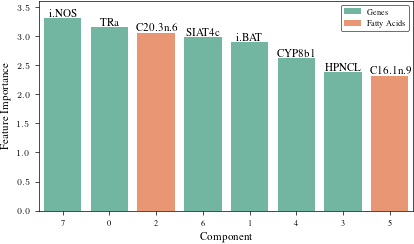

In [24]:
colors = {color: matplotlib.colormaps["Set2"].colors[i] for i,color in enumerate(selected_features["Modality"].unique())}
selected_features["color"] = selected_features["Modality"].apply(lambda x: colors[x])
plt.figure(figsize= (4.2, 2.5))
ax = sns.barplot(data=selected_features, x="Component", y="Feature Importance", hue="Modality", 
                 order= selected_features["Component"], dodge= False, palette="Set2")
ax.legend(title= None, loc= "upper right")
ax.set_ylim((0, selected_features["Feature Importance"].max() + 0.3))
modalities = selected_features["Modality"].unique()
for container in ax.containers:
    ax.bar_label(container, labels=selected_features["Feature"])
plt.savefig("paper_figures/selection.pdf")
plt.savefig("paper_figures/selection.svg")